<font size="+3"><strong> Bankruptcy in Taiwan 🇹🇼</strong></font>

In [2]:
# Import libraries here
import gzip
import json
import pickle
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import wqet_grader
from imblearn.over_sampling import RandomOverSampler
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget

# Prepare Data

## Import

**Task 5.5.1:** Load the contents of the `"data/taiwan-bankruptcy-data.json.gz"` and assign it to the variable <code>taiwan_data</code>. 
​


In [3]:
# Load data file
with gzip.open("data/taiwan-bankruptcy-data.json.gz","r") as f:
        taiwan_data = json.load(f)
print(type(taiwan_data))

<class 'dict'>


**Task 5.5.2:** Extract the key names from <code>taiwan_data</code> and assign them to the variable <code>taiwan_data_keys</code>.

In [4]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'observations', 'metadata'])


**Task 5.5.3:** Calculate how many companies are in `taiwan_data` and assign the result to `n_companies`. 

In [5]:
n_features = len(taiwan_data["observations"][0])
print(n_features)

97


**Task 5.5.5:** Create a `wrangle` function that takes as input the path of a compressed JSON file and returns the file's contents as a DataFrame. Be sure that the index of the DataFrame contains the ID of the companies. When your function is complete, use it to load the data into the DataFrame `df`.

In [15]:
# Create wrangle function
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    # Load dictionary into DataFrame, set index
    df=pd.DataFrame.from_dict(data["observations"]).set_index("id")
    return df

In [24]:
df = wrangle("data/taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,...,Attr_86,Attr_87,Attr_88,Attr_89,Attr_90,Attr_91,Attr_92,Attr_93,Attr_94,Attr_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [25]:
df["bankrupt"].value_counts()

False    5943
True      194
Name: bankrupt, dtype: int64

## Explore

**Task 5.5.6:** Is there any missing data in the dataset? Create a Series where the index contains the name of the columns in `df` and the values are the number of <code>NaN</code>s in each column. Assign the result to <code>nans_by_col</code>. Neither the Series itself nor its index require a name. 

In [8]:
df.isnull().sum()

bankrupt    0
Attr_1      0
Attr_2      0
Attr_3      0
Attr_4      0
           ..
Attr_91     0
Attr_92     0
Attr_93     0
Attr_94     0
Attr_95     0
Length: 96, dtype: int64

In [9]:
nans_by_col = pd.Series(df.isnull().sum())
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


bankrupt    0
Attr_1      0
Attr_2      0
Attr_3      0
Attr_4      0
dtype: int64

**Task 5.5.7:** Is the data imbalanced? Create a bar chart that shows the normalized value counts for the column `df["bankrupt"]`. Be sure to label your x-axis `"Bankrupt"`, your y-axis `"Frequency"`, and use the title `"Class Balance"`.

<AxesSubplot:title={'center':'class balance'}, xlabel='bankrupt', ylabel='frequency'>

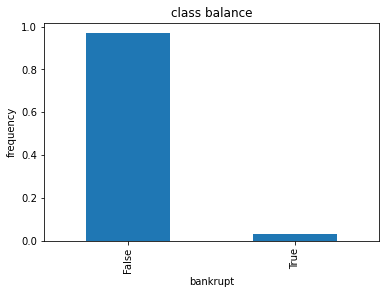

In [26]:
# Plot class balance
df["bankrupt"].value_counts(normalize=True).plot(
    kind ="bar",
    xlabel="bankrupt",
    ylabel="frequency",
    title="class balance"
)

## Split

**Task 5.5.8:** Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 

In [27]:
target = "bankrupt"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


**Task 5.5.9:** Divide your dataset into training and test sets using a randomized split. Your test set should be 20% of your data. Be sure to set `random_state` to `42`.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2 , random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


## Resample

**Task 5.5.10:** Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data. Be sure to set the `random_state` to `42`.

In [29]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (9506, 95)


,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,Attr_10,...,Attr_86,Attr_87,Attr_88,Attr_89,Attr_90,Attr_91,Attr_92,Attr_93,Attr_94,Attr_95
0,0.506167,0.568360,0.553563,0.595158,0.595187,0.998984,0.797402,0.809323,0.303514,0.781581,...,0.811337,0.001729,0.623492,0.595156,0.841980,0.286225,0.026981,0.565927,1,0.018617
1,0.468678,0.497928,0.521548,0.587714,0.587714,0.998757,0.797179,0.809117,0.303599,0.781363,...,0.774070,0.006710,0.624140,0.587714,0.838442,0.278596,0.026640,0.564319,1,0.034963
2,0.543265,0.589730,0.602923,0.611049,0.611049,0.999169,0.797580,0.809493,0.303438,0.781776,...,0.818833,0.004115,0.624494,0.611049,0.842961,0.286459,0.026950,0.565816,1,0.018451
3,0.494759,0.557948,0.541571,0.597666,0.597666,0.998992,0.797439,0.809350,0.303564,0.781611,...,0.811436,0.002108,0.623788,0.597663,0.841389,0.280616,0.026833,0.565351,1,0.026543
4,0.529177,0.600360,0.584346,0.603843,0.603713,0.999014,0.797568,0.809475,0.303743,0.781746,...,0.834857,0.009962,0.623576,0.603844,0.842959,0.278878,0.026799,0.565197,1,0.033299


# Build Model

## Iterate

**Task 5.5.11:** Create a classifier <code>clf</code> that can be trained on `(X_train_over, y_train_over)`. You can use any of the predictors you've learned about in the Data Science Lab. 

In [30]:
clf = GradientBoostingClassifier()

**Task 5.5.12:** Perform cross-validation with your classifier using the over-sampled training data, and assign your results to <code>cv_scores</code>. Be sure to set the <code>cv</code> argument to 5. 

In [31]:
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print(cv_scores)

[0.97250509 0.97046843 0.97046843 0.96639511 0.9714577 ]


Create a dictionary params with the range of hyperparameters that you want to evaluate for your classifier. If you're not sure which hyperparameters to tune, check the scikit-learn documentation for your predictor for ideas.

In [32]:
params = {
    "n_estimators":range(25,100,25),
    "max_depth":range(10,50,10)
}

**Task 5.5.13:** Create a <code>GridSearchCV</code> named `model` that includes your classifier and hyperparameter grid. Be sure to set `cv` to 5, `n_jobs` to -1, and `verbose` to 1. 

In [33]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

Fit your model to the over-sampled training data. 

In [34]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

**Task 5.5.14:** Extract the cross-validation results from your model, and load them into a DataFrame named <code>cv_results</code>. Looking at the results, which set of hyperparameters led to the best performance?

In [35]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.136694,0.681305,0.011370,0.000489,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.985279,0.982641,0.984219,0.984745,0.984745,0.984326,0.000907,12
1,40.039924,0.656302,0.016356,0.001955,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.986856,0.986849,0.989479,0.987901,0.990531,0.988323,0.001464,10
2,61.182783,0.843018,0.021343,0.004397,10,75,"{'max_depth': 10, 'n_estimators': 75}",0.988959,0.987901,0.991057,0.990531,0.993161,0.990322,0.001809,3
3,20.075912,0.666936,0.013165,0.000747,20,25,"{'max_depth': 20, 'n_estimators': 25}",0.987382,0.985271,0.988427,0.987375,0.987375,0.987166,0.001031,11
4,43.138837,3.992258,0.019947,0.001410,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.988433,0.990005,0.993161,0.989479,0.990531,0.990322,0.001580,2


**Task 5.5.15:** Extract the best hyperparameters from your model and assign them to <code>best_params</code>. 

In [36]:
best_params = model.best_params_
print(best_params)

{'max_depth': 20, 'n_estimators': 75}


## Evaluate

Test the quality of your model by calculating accuracy scores for the training and test data.

In [37]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)
print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 1.0
Model Test Accuracy: 0.9625


**Task 5.5.16:** Plot a confusion matrix that shows how your model performed on your test set.

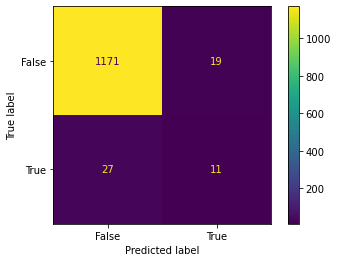

In [38]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

**Task 5.5.17:** Generate a classification report for your model's performance on the test data and assign it to `class_report`.

In [39]:
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1190
        True       0.37      0.29      0.32        38

    accuracy                           0.96      1228
   macro avg       0.67      0.64      0.65      1228
weighted avg       0.96      0.96      0.96      1228



# Communicate

**Task 5.5.18:** Create a horizontal bar chart with the 10 most important features for your model. Be sure to label the x-axis `"Gini Importance"`, the y-axis `"Feature"`, and use the title `"Feature Importance"`.

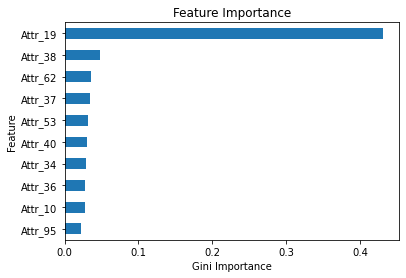

In [40]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

**Task 5.5.19:** Save your best-performing model to a a file named <code>"model-5-5.pkl"</code>.

In [41]:
# Save model
with open("model-5-5.pkl","wb") as f :
    pickle.dump(model.best_estimator_,f)

**Task 5.5.20:** Open the file <code>my_predictor_assignment.py</code>. Add your `wrangle` function, and then create a `make_predictions` function that takes two arguments: `data_filepath` and <code>model_filepath</code>. Use the cell below to test your module. 

In [44]:
with open('my_predictor_assignment.py', 'r') as file:
    contents = file.read()
    print(contents)

# Create your masterpiece :)

# Import libraries
import gzip
import json
import pickle

import pandas as pd


def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    # Load dictionary into DataFrame, set index
    df=pd.DataFrame.from_dict(data["observations"]).set_index("id")
    return df


def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open (model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred


In [46]:
# Import your module
from my_predictor_assignment import make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath="data/taiwan-bankruptcy-data-test-features.json.gz",
    model_filepath="model-5-5.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


id
10    False
13     True
40    False
41    False
71    False
Name: bankrupt, dtype: bool